In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import product
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import torch.nn.init as init

In [2]:
#check for GPU availability
torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define Functions

## 1) function to preprocess (1-hot encode) MONK data

In [3]:
def preprocess_monk(file_name):
    '''
    Load data from the Monk dataset and preprocess using one-hot encoding.

    Parameters:
    - file_name (str): The file name of the dataset.

    Returns:
    - x (torch.Tensor): Input data after one-hot encoding.
    - y (torch.Tensor): Target data.
    '''

    # load the dataset, split into input (X) and output (y) variables
    df = pd.read_csv(file_name, delimiter=' ', header=None,
                     names=['_','target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'data_number'],
                     index_col=False)

    # Extract input features and target variable
    x1, x2, x3, x4, x5, x6, target = (np.array(df[feature]) for feature in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'target'])

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)

    # Reshape and transform x1 using one-hot encoding
    input_one_hot = encoder.fit_transform(x1.reshape(-1, 1))

    # Loop through the remaining input features and concatenate one-hot encoded values
    for x in [x2,x3,x4,x5,x6]:
        data =x.reshape(-1, 1)
        one_hot_encoded = encoder.fit_transform(data)
        input_one_hot = np.hstack((input_one_hot, one_hot_encoded))

    # Convert to PyTorch tensors
    x = torch.tensor(input_one_hot, dtype=torch.float32)#.cuda()
    y = torch.tensor(target, dtype=torch.float32).reshape(-1,1)#.cuda()

    return x, y

## Function to plot training curves

In [4]:
def plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams):
    '''
    Plot training and test curves for loss and accuracy.

    Parameters:
    - epoch (int): The number of epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - test_accuracies (list): List of test accuracies for each epoch.
    - hyperparams (list): List of hyperparameters [hidden_units, lr, alpha, batch_size, lambda].

    Returns:
    None
    '''
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Batch Size={hyperparams[3]}, Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}')
    # Loss plots
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plots
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='red')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define the model

In [5]:
# Define the classifier

class MonkClassifier(nn.Module):
    def __init__(self, hidden_size, input_size=17, output_size=1, weight_init_constant=0.01):
        super(MonkClassifier, self).__init__()

        # Custom weight initialization function
        #def init_weights(m):
        #    if type(m) == nn.Linear:
        #        if hasattr(m, 'weight') and m.weight is not None:
        #            init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        #            if m.bias is not None:
        #               init.constant_(m.bias, 0)

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

        # Apply custom weight initialization to linear layers
        #self.apply(init_weights)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

In [6]:
def training_model(x_train, y_train, x_test, y_test, hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs=1000, plot_curves=False):
    '''
    Train a Monk classifier model.

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test (or Validation) input data.
    - y_test (torch.Tensor): Test (or Validation) target data.
    - hidden_size (int): Size of the hidden layer in the model.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - batch_size (int): Batch size for training and testing.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - num_epochs (int): Maximum number of training epochs (default: 1000).
    - plot_curves (bool): Whether to plot training curves (default: False).

    Returns:
    - epoch (int): Number of epochs completed.
    - train_loss (float): Final training loss.
    - test_loss (float): Final test (or validation) loss.
    - train_accuracy (float): Final training accuracy.
    - test_accuracy (float): Final test (or validation) accuracy.
    '''

    # Create an instance of the model
    model = MonkClassifier(hidden_size)
    #model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

    # Lists to store training and test losses for plotting
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    # parameters to stop at training convergence
    prev_loss = float('inf')
    #prev_accuracy = 0
    patience_counter, patience = 0, 20

    for epoch in range(num_epochs):
        #calculate loss
        y_pred = model(x_train)
        train_loss = criterion(y_pred, y_train)
        # Calculate accuracy
        predicted_labels = torch.round(y_pred)
        correct_predictions = (predicted_labels == y_train).sum().item()
        total_samples = y_train.size(0)
        accuracy = correct_predictions / total_samples

        train_losses.append(train_loss.item())
        train_accuracies.append(accuracy)

        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels) #Compute the loss

            optimizer.zero_grad()   # Zero the gradients
            loss.backward() # Backward pass
            optimizer.step()  # Update weights

        # Evaluation on the test/validation set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)

            # Calculate test accuracy
            predicted_test_labels = torch.round(test_outputs)
            correct_test_predictions = (predicted_test_labels == y_test).sum().item()
            total_test_samples = y_test.size(0)
            test_accuracy = correct_test_predictions / total_test_samples

            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss.item())

        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, '
            f'Accuracy: {accuracy:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} Accuracy: {test_accuracy:.4f} ', end='\r')

        # Check for convergence
        if abs(prev_loss - train_loss.item()) < 1e-5:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break
        prev_loss = train_loss.item()

    print(f'\n N. Epochs = {epoch+1} - Loss (train | test)= ({train_loss.item():.4} | {test_loss.item():.4}) - Accuracy (train | test) = ({accuracy} | {test_accuracy})')

    if plot_curves:
        hyperparams = [hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs]
        plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams)

    return epoch+1, train_loss.item(), test_loss.item(), accuracy, test_accuracy

In [7]:
def perform_grid_search_kfold(hidden_sizes, learning_rates, momentums, batch_sizes, reg_coeffs, k_folds, x, y, plot_curves=False):
    '''
    Perform grid search with k-fold cross-validation for Monk classifier hyperparameters.

    Parameters:
    - hidden_sizes (list): List of hidden layer sizes to explore.
    - learning_rates (list): List of learning rates to explore.
    - momentums (list): List of momentum values to explore.
    - batch_sizes (list): List of batch sizes to explore.
    - reg_coeffs (list): List of regularization coefficients to explore.
    - k_folds (int): Number of folds for cross-validation.
    - x (torch.Tensor): Input data.
    - y (torch.Tensor): Target data.
    - plot_curves (bool): Whether to plot training curves for each hyperparameter combination (default: False).

    Returns:
    - best_hyperparams (list): List of best hyperparameters based on highest average validation accuracy.
    '''

    best_acc = 0
    best_hyperparams = []

    for hidden_size, learning_rate, momentum, bs, reg_coeff in product(hidden_sizes,learning_rates,momentums,batch_sizes, reg_coeffs):
        print(f'hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}')

        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and accuracies for each epoch
        train_losses, val_losses, train_acc, val_acc = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            max_epoch, average_loss, average_val_loss, average_accuracy, average_val_accuracy = training_model(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                hidden_size=hidden_size, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, plot_curves=plot_curves)

            train_losses.append(average_loss)
            val_losses.append(average_val_loss)
            train_acc.append(average_accuracy)
            val_acc.append(average_val_accuracy)

        print(f'Final Results: hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_acc = {np.mean(train_acc):.4} +- {np.std(train_acc):.4} | '
            f'val_acc = {np.mean(val_acc):.4} +- {np.std(val_acc):.4}')

        if np.mean(val_acc) >= best_acc:
            best_acc = np.mean(val_acc)
            best_hyperparams = [hidden_size, learning_rate, momentum, bs, reg_coeff]

    print(best_hyperparams)
    return best_hyperparams

In [8]:
def train_with_different_initializations(x_train, y_train, x_test, y_test,
                                         hidden_size,learning_rate, momentum,
                                         bs, reg_coeff, num_epochs=1000,
                                         plot_curves=False, N = 5):
    '''
    train the model N times with different weight initializations,
    to estimate the model performances with mean and variance
    '''
    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    for i in range (0,N):
        _, train_loss, test_loss, train_acc, test_acc = training_model(x_train,
                        y_train,
                        x_test,
                        y_test,
                        hidden_size,
                        learning_rate,
                        momentum,
                        bs,
                        reg_coeff,
                        plot_curves=plot_curves)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    print(f'Train Loss: {np.mean(train_losses):.4} +- {np.std(train_losses):.4}')
    print(f'Test Loss: {np.mean(test_losses):.4} +- {np.std(test_losses):.4}')
    print(f'Train Acc: {np.mean(train_accs)*100:.4} +- {np.std(train_accs)*100:.4} %')
    print(f'Test Acc: {np.mean(test_accs)*100:.4} +- {np.std(test_accs)*100:.4} %')


# Monk 1

In [9]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-1.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-1.test')

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([124, 17])
torch.Size([124, 1])
torch.Size([432, 17])
torch.Size([432, 1])


## Perform Model Selection using a grid serch with k-fold cross validation

inizialmente modificare gli iperparametri ad occhio per avere un'idea di cosa succede,
poi fare una grid search più fine 

In [25]:
hidden_sizes = [4, 5]
learning_rates = [0.01,0.1]
momentums = [0.7,0.8,0.9]
batch_sizes = [4,16,32]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=4; lr=0.01; alpha = 0.7; batch size = 4; lambda = 0
Training - Epoch [1000/1000], Loss: 0.0076, Accuracy: 1.0000 | Test - Epoch [1000/1000], Loss: 0.0191 Accuracy: 0.9600 
 N. Epochs = 1000 - Loss (train | test)= (0.007583 | 0.01908) - Accuracy (train | test) = (1.0 | 0.96)
Training - Epoch [834/1000], Loss: 0.0236, Accuracy: 0.9794 | Test - Epoch [834/1000], Loss: 0.1405 Accuracy: 0.8400 
 N. Epochs = 834 - Loss (train | test)= (0.02365 | 0.1405) - Accuracy (train | test) = (0.979381443298969 | 0.84)


KeyboardInterrupt: 

## Train the model (with best hyperparameters) using different weights initiaizatons
in order to estimate a mean and variance for the performance

In [11]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

Training - Epoch [537/1000], Loss: 0.0022, Accuracy: 1.0000 | Test - Epoch [537/1000], Loss: 0.0045 Accuracy: 1.0000 
 N. Epochs = 537 - Loss (train | test)= (0.002155 | 0.004496) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [830/1000], Loss: 0.0051, Accuracy: 1.0000 | Test - Epoch [830/1000], Loss: 0.0102 Accuracy: 1.0000 
 N. Epochs = 830 - Loss (train | test)= (0.005057 | 0.0102) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [534/1000], Loss: 0.0019, Accuracy: 1.0000 | Test - Epoch [534/1000], Loss: 0.0057 Accuracy: 1.0000 
 N. Epochs = 534 - Loss (train | test)= (0.001903 | 0.005689) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [675/1000], Loss: 0.0026, Accuracy: 1.0000 | Test - Epoch [675/1000], Loss: 0.0047 Accuracy: 1.0000 
 N. Epochs = 675 - Loss (train | test)= (0.002571 | 0.004682) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [657/1000], Loss: 0.0017, Accuracy: 1.0000 | Test - Epoch [657/1000], Loss: 0.0084 Accuracy: 1.0000 
 N. 

# Retrain the model to make final plots

Training - Epoch [442/1000], Loss: 0.0018, Accuracy: 1.0000 | Test - Epoch [442/1000], Loss: 0.0059 Accuracy: 1.0000 
 N. Epochs = 442 - Loss (train | test)= (0.001827 | 0.005922) - Accuracy (train | test) = (1.0 | 1.0)


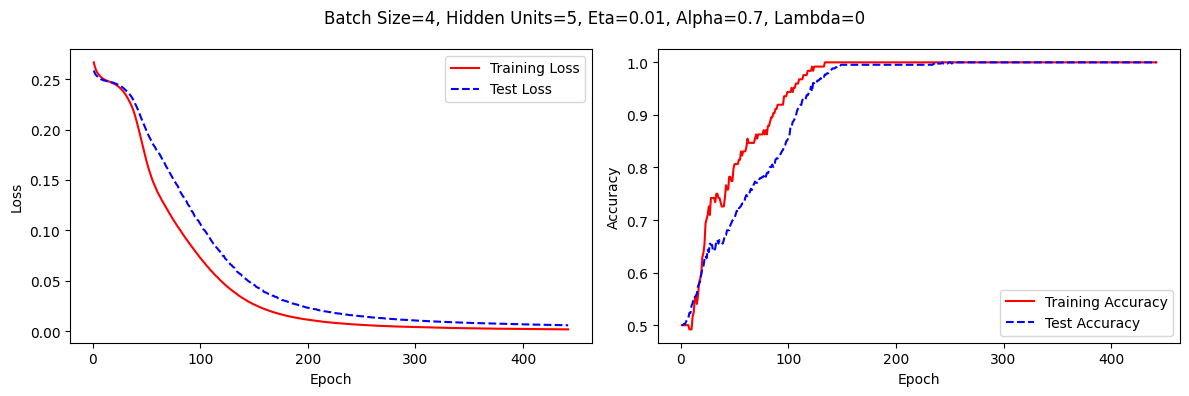

(442, 0.0018271291628479958, 0.005922257900238037, 1.0, 1.0)

In [12]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 2

In [13]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-2.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-2.test')

In [14]:
hidden_sizes = [5]
learning_rates = [0.1]
momentums = [0.8]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.1; alpha = 0.8; batch size = 4; lambda = 0
Training - Epoch [136/1000], Loss: 0.0006, Accuracy: 1.0000 | Test - Epoch [136/1000], Loss: 0.0843 Accuracy: 0.9118 
 N. Epochs = 136 - Loss (train | test)= (0.0005518 | 0.0843) - Accuracy (train | test) = (1.0 | 0.9117647058823529)
Training - Epoch [126/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [126/1000], Loss: 0.0006 Accuracy: 1.0000 
 N. Epochs = 126 - Loss (train | test)= (0.0004271 | 0.0005586) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [97/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [97/1000], Loss: 0.0004 Accuracy: 1.0000 
 N. Epochs = 97 - Loss (train | test)= (0.0003958 | 0.0003866) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [85/1000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [85/1000], Loss: 0.0004 Accuracy: 1.0000 
 N. Epochs = 85 - Loss (train | test)= (0.0002869 | 0.0003711) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [97/1000], Loss: 0.0004, A

In [15]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

Training - Epoch [280/1000], Loss: 0.0300, Accuracy: 0.9704 | Test - Epoch [280/1000], Loss: 0.0568 Accuracy: 0.9444 
 N. Epochs = 280 - Loss (train | test)= (0.02998 | 0.05679) - Accuracy (train | test) = (0.9704142011834319 | 0.9444444444444444)
Training - Epoch [99/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [99/1000], Loss: 0.0005 Accuracy: 1.0000 
 N. Epochs = 99 - Loss (train | test)= (0.0004009 | 0.0005409) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [110/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [110/1000], Loss: 0.0004 Accuracy: 1.0000 
 N. Epochs = 110 - Loss (train | test)= (0.0003563 | 0.0003696) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [75/1000], Loss: 0.0002, Accuracy: 1.0000 | Test - Epoch [75/1000], Loss: 0.0003 Accuracy: 1.0000 
 N. Epochs = 75 - Loss (train | test)= (0.0002451 | 0.0002859) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [101/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [101/1000], Loss:

Training - Epoch [102/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [102/1000], Loss: 0.0004 Accuracy: 1.0000 
 N. Epochs = 102 - Loss (train | test)= (0.000383 | 0.0004292) - Accuracy (train | test) = (1.0 | 1.0)


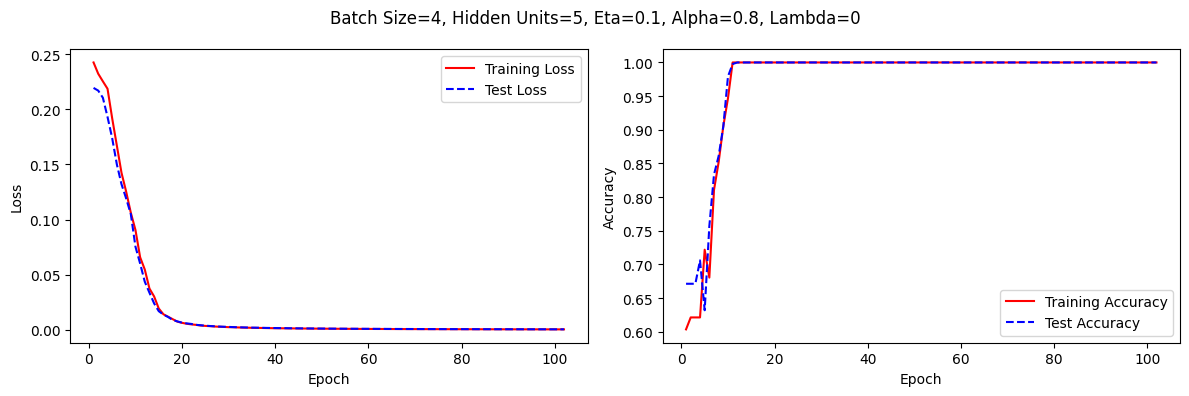

(102, 0.000383030652301386, 0.000429183040978387, 1.0, 1.0)

In [16]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 3 (no regularization)

In [17]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

In [18]:
hidden_sizes = [5]
learning_rates = [0.1,0.01,0.001]
momentums = [0.8]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.1; alpha = 0.8; batch size = 4; lambda = 0
Training - Epoch [169/1000], Loss: 0.0106, Accuracy: 0.9897 | Test - Epoch [169/1000], Loss: 0.0005 Accuracy: 1.0000 
 N. Epochs = 169 - Loss (train | test)= (0.01061 | 0.0005051) - Accuracy (train | test) = (0.9896907216494846 | 1.0)
Training - Epoch [190/1000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [190/1000], Loss: 0.1687 Accuracy: 0.8000 
 N. Epochs = 190 - Loss (train | test)= (0.0004923 | 0.1687) - Accuracy (train | test) = (1.0 | 0.8)
Training - Epoch [348/1000], Loss: 0.0052, Accuracy: 0.9898 | Test - Epoch [348/1000], Loss: 0.0447 Accuracy: 0.9167 
 N. Epochs = 348 - Loss (train | test)= (0.005199 | 0.04468) - Accuracy (train | test) = (0.9897959183673469 | 0.9166666666666666)
Training - Epoch [203/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [203/1000], Loss: 0.1089 Accuracy: 0.8750 
 N. Epochs = 203 - Loss (train | test)= (0.0004452 | 0.1089) - Accuracy (train | test) = (1.0 | 0.875)
Training - Ep

In [19]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

Training - Epoch [1000/1000], Loss: 0.0428, Accuracy: 0.9508 | Test - Epoch [1000/1000], Loss: 0.0388 Accuracy: 0.9583 
 N. Epochs = 1000 - Loss (train | test)= (0.04278 | 0.03884) - Accuracy (train | test) = (0.9508196721311475 | 0.9583333333333334)
Training - Epoch [1000/1000], Loss: 0.0468, Accuracy: 0.9508 | Test - Epoch [1000/1000], Loss: 0.0449 Accuracy: 0.9560 
 N. Epochs = 1000 - Loss (train | test)= (0.04675 | 0.04485) - Accuracy (train | test) = (0.9508196721311475 | 0.9560185185185185)
Training - Epoch [1000/1000], Loss: 0.0440, Accuracy: 0.9508 | Test - Epoch [1000/1000], Loss: 0.0411 Accuracy: 0.9560 
 N. Epochs = 1000 - Loss (train | test)= (0.044 | 0.04112) - Accuracy (train | test) = (0.9508196721311475 | 0.9560185185185185)
Training - Epoch [1000/1000], Loss: 0.0435, Accuracy: 0.9508 | Test - Epoch [1000/1000], Loss: 0.0404 Accuracy: 0.9583 
 N. Epochs = 1000 - Loss (train | test)= (0.04348 | 0.04039) - Accuracy (train | test) = (0.9508196721311475 | 0.9583333333333334

Training - Epoch [1000/1000], Loss: 0.0479, Accuracy: 0.9426 | Test - Epoch [1000/1000], Loss: 0.0428 Accuracy: 0.9630 
 N. Epochs = 1000 - Loss (train | test)= (0.0479 | 0.04279) - Accuracy (train | test) = (0.9426229508196722 | 0.9629629629629629)


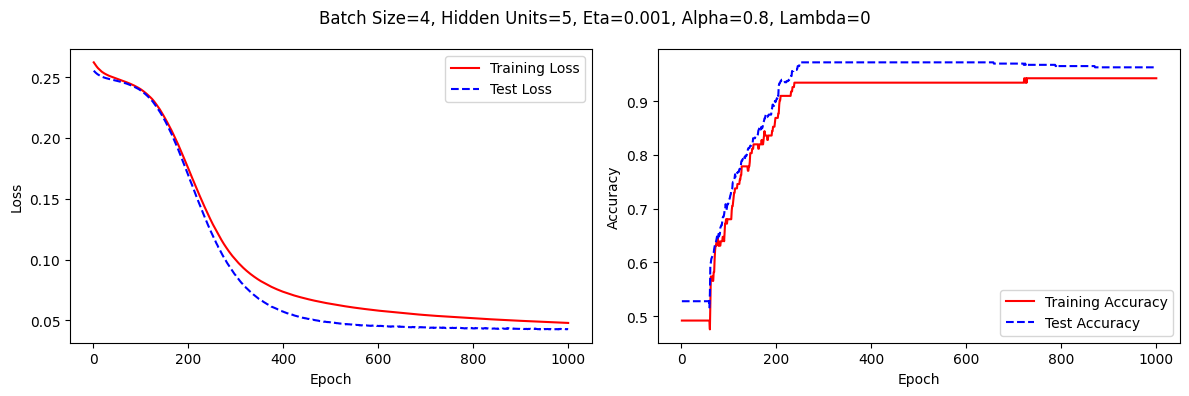

(1000,
 0.047898318618535995,
 0.042789340019226074,
 0.9426229508196722,
 0.9629629629629629)

In [20]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 3 (with regularization)

In [21]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

In [22]:
hidden_sizes = [8]
learning_rates = [0.001]
momentums = [0.8]
batch_sizes = [4]
reg_coeffs = [0.01]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=8; lr=0.001; alpha = 0.8; batch size = 4; lambda = 0.01
Training - Epoch [1000/1000], Loss: 0.0729, Accuracy: 0.9175 | Test - Epoch [1000/1000], Loss: 0.0383 Accuracy: 1.0000 
 N. Epochs = 1000 - Loss (train | test)= (0.07292 | 0.03829) - Accuracy (train | test) = (0.9175257731958762 | 1.0)
Training - Epoch [1000/1000], Loss: 0.0534, Accuracy: 0.9485 | Test - Epoch [1000/1000], Loss: 0.1080 Accuracy: 0.8800 
 N. Epochs = 1000 - Loss (train | test)= (0.05336 | 0.108) - Accuracy (train | test) = (0.9484536082474226 | 0.88)
Training - Epoch [1000/1000], Loss: 0.0689, Accuracy: 0.9286 | Test - Epoch [1000/1000], Loss: 0.0531 Accuracy: 0.9583 
 N. Epochs = 1000 - Loss (train | test)= (0.06888 | 0.05311) - Accuracy (train | test) = (0.9285714285714286 | 0.9583333333333334)
Training - Epoch [977/1000], Loss: 0.0535, Accuracy: 0.9490 | Test - Epoch [977/1000], Loss: 0.1298 Accuracy: 0.8750 
 N. Epochs = 977 - Loss (train | test)= (0.0535 | 0.1298) - Accuracy (train | test) = (0.948

In [23]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

Training - Epoch [1000/1000], Loss: 0.0756, Accuracy: 0.9344 | Test - Epoch [1000/1000], Loss: 0.0578 Accuracy: 0.9722 
 N. Epochs = 1000 - Loss (train | test)= (0.07562 | 0.05777) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [1000/1000], Loss: 0.0636, Accuracy: 0.9344 | Test - Epoch [1000/1000], Loss: 0.0488 Accuracy: 0.9722 
 N. Epochs = 1000 - Loss (train | test)= (0.0636 | 0.04875) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [808/1000], Loss: 0.0651, Accuracy: 0.9344 | Test - Epoch [808/1000], Loss: 0.0503 Accuracy: 0.9722 
 N. Epochs = 808 - Loss (train | test)= (0.06507 | 0.05028) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [707/1000], Loss: 0.0647, Accuracy: 0.9344 | Test - Epoch [707/1000], Loss: 0.0502 Accuracy: 0.9722 
 N. Epochs = 707 - Loss (train | test)= (0.06467 | 0.05021) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)


KeyboardInterrupt: 

N. Epochs = 273 - Loss (train | test)= (0.05909 | 0.05093) - Accuracy (train | test) = (0.9426229508196722 | 0.9629629629629629)


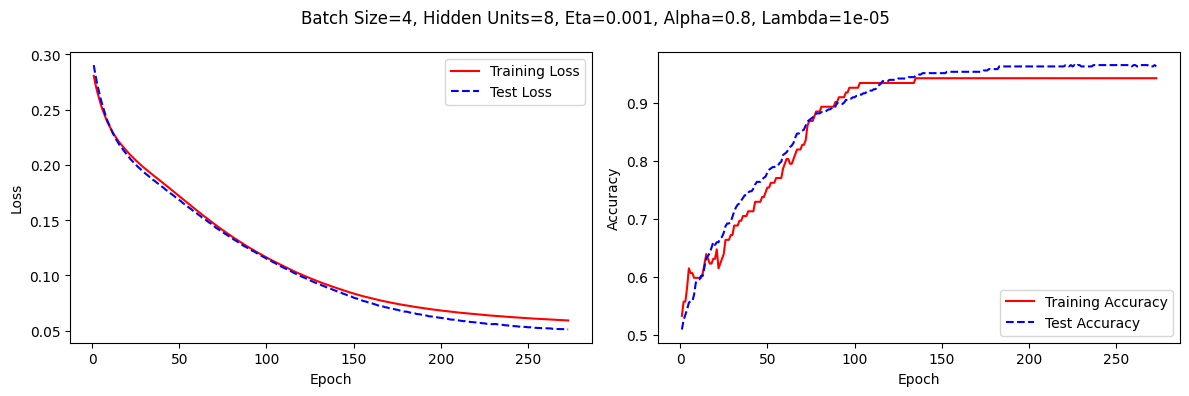

(273,
 0.05908682197332382,
 0.05093301087617874,
 0.9426229508196722,
 0.9629629629629629)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)